## 라이브러리

In [2]:
# 데이터 분석 기본 라이브러리 관련
import os
import sys
import warnings
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

# EDA 관련
import matplotlib
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# 데이터 전처리 관련
from datetime import datetime
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [4]:
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', 100)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

## 전체적으로 사용되는 함수

In [5]:
def MSG(x):
    if x['SMS\n수신여부']=='수신':
        return 'Y'
    else:
        return 'N'
    
def DateToStr1(x):
    return str(x['최종접수일'])

def DateToStr2(x):
    return str(x['가입일'])

def DateToStr3(x):
    return str(x['최종방문일▼'])

def DateToStr4(x):
    return str(x['최종방문일'])

def StringToStr(x):
    return str(x['고객번호'])

---
## 데이터불러오기

In [36]:
pos=pd.read_excel('./고객data/꿈꾸는이상(주) 길음신관_고객현황조회_20210316.xlsx')

In [37]:
res=pd.read_excel('./고객data/(갈비명가이상 길음신관)데이터_20210415.xlsx')

In [38]:
excel=pd.read_excel('./고객data/2018 04 길신.xlsx')

In [39]:
msg=pd.read_excel('./고객data/뿌리오지점별고객리스트.xlsx',skiprows=2)

In [40]:
pur=pd.read_excel('./고객data/고객구매정보_2004_2103.xlsx')

## 1) 포스데이터

In [41]:
print(pos.shape)

(14519, 21)


In [ ]:
pos.head()

#### 1. 각 열에 결측값 확인

In [42]:
pos.drop('NO',axis=1,inplace=True)
pos.isnull().sum()

고객번호             0
고객명              0
매장명              0
등급               0
성별               0
생년월일         13044
전화번호            58
핸드폰번호            1
구매금액             0
구매횟수             0
포인트              0
가입일              0
최종방문일▼           0
우편번호         14279
주소           14335
상세주소         14355
메일주소         14457
SMS\n수신여부        0
기념일          14518
비고           14518
dtype: int64

-> 생년월일, 전화번호, 우편번호, 주소, 상세주소, 메일주소, 기념일, 비고에 대해서 결측치 존재( 대부분의 데이터가 결측임 )
#### 2. 정보가 있는 데이터만 가져와서 새로운 데이터 셋 생성

In [43]:
pos.drop(['생년월일','전화번호','우편번호','주소','상세주소','메일주소','기념일','비고'],axis=1,inplace=True)

In [ ]:
pos

#### 3. easyPOS안의 길음신관 고객수

In [44]:
pos['고객번호'].nunique()

14519

#### 4. easyPOS안의 고객들의 기존 등급

In [45]:
pos['등급'].unique()

array(['일반', 'VIP 블루', 'VVIP회원', 'VIP 퍼플', '사용안함', 'VIP 블랙'], dtype=object)

In [46]:
a=pos['등급'].value_counts().reset_index()
a

,index,등급
0,일반,14474
1,VIP 블루,23
2,VIP 퍼플,16
3,VIP 블랙,4
4,VVIP회원,1
5,사용안함,1


In [ ]:
pos[pos['등급']=='VIP 블루']

In [ ]:
pos[pos['등급']=='VIP 퍼플']

In [ ]:
pos[(pos['등급']=='VIP 블랙')|(pos['등급']=='VVIP회원')|(pos['등급']=='사용안함')]

In [48]:
pos.groupby(['성별','등급']).size().unstack().fillna(0)

등급,VIP 블랙,VIP 블루,VIP 퍼플,VVIP회원,사용안함,일반
성별,,,,,,
남자,3.0,11.0,13.0,1.0,0.0,6386.0
여자,1.0,12.0,3.0,0.0,1.0,8088.0


#### 5. 달 별 가입한 고객의 수 & 그래프

In [49]:
a=pd.DataFrame(pos['가입일'].value_counts())
a=a.resample('1M').sum()
a

,가입일
2011-05-31,197
2011-06-30,295
2011-07-31,189
2011-08-31,192
2011-09-30,99
...,...
2020-08-31,82
2020-09-30,71
2020-10-31,83
2020-11-30,75


Text(0.5, 1.0, '월별 길음신관 신규 가입자 수')

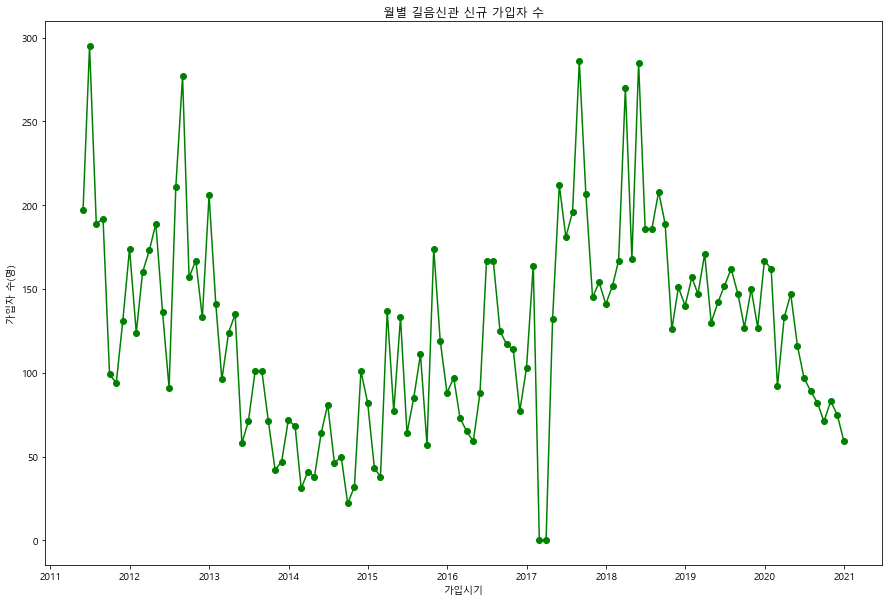

In [50]:
plt.figure(figsize=(15,10))
plt.plot(a.index,a['가입일'], marker="o", color = "green")
plt.xlabel('가입시기')
plt.ylabel('가입자 수(명)')
plt.title('월별 길음신관 신규 가입자 수')

#### 6. 달 별 최종방문한 고객수 & 그래프

Text(0.5, 1.0, '월별 길음신관 최종 방문자 수')

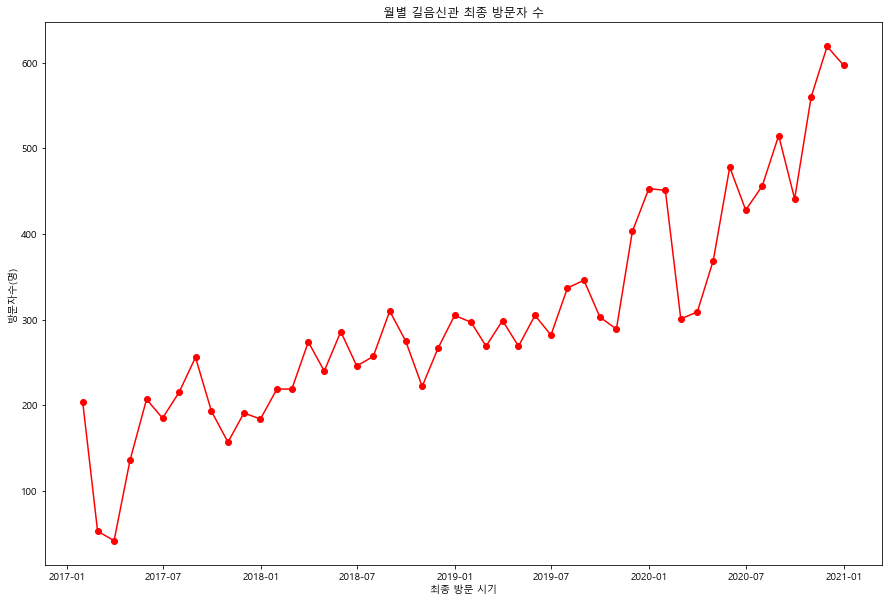

In [51]:
a=pd.DataFrame(pos['최종방문일▼'].value_counts())
a=a.resample('1M').sum()
plt.figure(figsize=(15,10))
plt.plot(a.index,a['최종방문일▼'], marker="o", color = "red")
plt.xlabel('최종 방문 시기')
plt.ylabel('방문자수(명)')
plt.title('월별 길음신관 최종 방문자 수')

#### 다른 데이터 셋과 merge하기 위한 작업

In [52]:
pos['문자수신여부']=pos.apply(MSG,axis=1)
pos.drop('SMS\n수신여부',axis=1,inplace=True)

In [53]:
pos['연락처']=pos['핸드폰번호'].str.replace("-","")
pos.drop('핸드폰번호',axis=1,inplace=True)

In [54]:
pos['고객번호']=pos.apply(StringToStr,axis=1)
pos['고객번호']=pos['고객번호'].str.pad(width=8,side='left',fillchar='0')

In [55]:
pos['최종방문일▼']=pos.apply(DateToStr3,axis=1)

In [56]:
pos.rename(columns={'최종방문일▼':'최종방문일'},inplace=True)

#### 7. pos에 대한 최종 데이터 셋
- 정보가 없는 변수 제거 : 생년월일, 우편번호, 주소, 상세주소, 메일주소, 기념일 ,비고
- 변형 이유 : 다른 데이터 셋과 형태를 동일하게 만들기 위함
- 변형한 변수\
최종방문일▼ => 최종방문일
연락처(000-0000-0000 => 00000000000)\
SMS\n수신여부(미수신, 수신) => 문자수신여부(N,Y)

In [ ]:
pos.head()

## 예약고객

In [ ]:
res.head()

#### 1. 총 3792명의 길음신관 예약고객

In [57]:
res.shape

(3792, 18)

#### 2. 총 예약횟수 = 예약완료 + 취소 + 노쇼
- 모든 데이터가 이를 만족함 (오류X)

In [58]:
res[res['총 예약횟수'] == (res['예약완료']+ res['취소'] + res['노쇼'])].shape

(3792, 18)

#### 3. 별칭은 통일되는 정보가 없음
- 별칭에 이름이 적혀있는 정보가 있음 -> 고객명 수정
- 나머지는 변수에서 제외

In [59]:
res['별칭'].unique()

array(['-', '미역국', '길음복지관', '안희광'], dtype=object)

In [ ]:
res[res['별칭']!='-']

#### 4. 예약시 특징에 대한 정보가 채워져 있음
- 예약시마다 달라지는 개인적인 내용이기 때문에 변수에서 제외

In [60]:
res['고객메모'].unique()

array(['-', '미역국', '갈비탕', '증명서', '탕', '생일상요청(환갑}', '왕본이지만 단독으로.....',
       '가족관계증명서', '이상', '배영순님에약자', '이상정식', '청난회', '전화드림', '가족관계증명서, 회갑연',
       '가족관계증명서 확인', '증명서확인', '돌잔치 증명서'], dtype=object)

#### 5. 고객그룹은 -, test로 이루어져 있음
- 고객그룹이 test인 고객정보

In [61]:
res['고객그룹'].unique()

array(['-', 'test'], dtype=object)

In [ ]:
res[res['고객그룹']=='test']

#### 6. 메뉴 이용 금액에 대한 정보가 완전치 못함
- 변수에서 제외

In [62]:
res['메뉴이용금액'].unique()

array([     0, 248000,  81000], dtype=int64)

In [ ]:
res[res['메뉴이용금액']!=0]

#### 7. 노쇼레벨별 차이점을 명확히 하기 어려움
- 변수에서 제외

In [63]:
res['노쇼레벨'].unique()

array([0, 3, 1, 2], dtype=int64)

In [ ]:
res[res['노쇼레벨']==0]

In [ ]:
res[res['노쇼레벨']==1]

In [ ]:
res[res['노쇼레벨']==2]

In [ ]:
res[res['노쇼레벨']==3]

#### 8. 정보가 불충분한 고객번호, 별칭, 고객메모, 고객그룹, 메뉴이용금액, 수신거부일, 노쇼레벨을 변수에서 제거

In [64]:
res.drop(['고객번호','별칭','고객메모','고객그룹','메뉴이용금액','수신거부일','노쇼레벨'],axis=1,inplace=True)

In [ ]:
res.head()

#### 다른 데이터 셋과 merge하기 위한 작업

In [65]:
res.replace('-',np.nan,inplace=True)

In [ ]:
res.head()

In [66]:
res['0']=0
cols=['0','휴대전화번호']
res['휴대전화번호']=res[cols].apply(lambda row:"".join(row.values.astype(str)),axis=1)
res.drop('0',axis=1,inplace=True)

In [ ]:
res.head()

In [67]:
res['최종접수일']=res.apply(DateToStr1,axis=1)
res['가입일']=res.apply(DateToStr2,axis=1)
res['최종방문일']=res.apply(DateToStr4,axis=1)
res['최종접수일']=res['최종접수일'].str[:10]
res['가입일']=res['가입일'].str[:10]
res.rename(columns={'휴대전화번호':'연락처'},inplace=True)

#### 9. 최종 예약 고객 데이터
- 정보가 없는 변수 제거 : 고객번호, 별칭, 고객메모, 고객그룹, 메뉴이용금액, 수신거부일, 노쇼레벨
- 변형이유 : 다른 데이터 셋과 형태를 동일하게 만들기 위해
- 변형한 변수 : \
연락처(0000000000 => 00000000000)

In [ ]:
res.head()

## 3) 엑셀고객

In [ ]:
excel

#### 다른 데이터 셋과 merge하기 위한 작업

In [68]:
excel['0']=0
cols=['0','연락처']
excel['연락처']=excel[cols].apply(lambda row:"".join(row.values.astype(str)),axis=1)
excel.drop('0',axis=1,inplace=True)

In [ ]:
excel.head()

In [69]:
excel.연락처.apply(lambda x: len(x)).value_counts()

11    341
10      2
Name: 연락처, dtype: int64

#### 이상하게 입력된 전화번호 삭제

In [ ]:
excel[excel.연락처.apply(lambda x: len(x))==10]

In [70]:
excel=excel[excel.연락처.apply(lambda x: len(x))==11]

#### 엑셀 길음신관 데이터 고객 341명

In [ ]:
excel

In [71]:
excel['연락처'].nunique()

341

## 뿌리오 문자

In [ ]:
msg.head()

#### 뿌리오 길음신관 고객수 19445명

In [72]:
msg.shape

(19445, 3)

#### 다른 데이터 셋과 합치기 위해
- 성함 -> 고객명
- 전화번호 -> 연락처

In [73]:
msg.drop('No.',axis=1,inplace=True)
msg.rename(columns={'성함':'고객명','전화번호':'연락처'},inplace=True)
msg['연락처']=msg['연락처'].str.replace('-','')

In [ ]:
msg.head()

In [74]:
msg.연락처.apply(lambda x: len(x)).value_counts()

11    19290
10      155
Name: 연락처, dtype: int64

In [ ]:
msg[msg.연락처.apply(lambda x: len(x))==10]

- 10자리 연락처 -> 과거에 사용되었던 연락처
- 11자리 연락처만 최종 데이터 셋으로 선정

In [75]:
msg=msg[msg.연락처.apply(lambda x: len(x))==11]

---
## 연락처 처리 
#### 1) 엑셀데이터(excel) + 뿌리오 데이터(msg)

In [76]:
phone=pd.merge(excel,msg,how='outer',on='연락처')

In [ ]:
phone

In [77]:
notsame=phone[(phone['고객명_x'].isnull()==0)&(phone['고객명_y'].isnull()==0)&(phone['고객명_x']!=phone['고객명_y'])]
print(notsame.shape)

(50, 3)


In [ ]:
notsame.head()

In [78]:
cols=['고객명_x','고객명_y']
notsame['고객명']=notsame[cols].apply(lambda row:' / '.join(row.values.astype(str)),axis=1)
notsame.drop(['고객명_x','고객명_y'],axis=1,inplace=True)

In [79]:
same=phone[(phone['고객명_x'].isnull()==0)&(phone['고객명_y'].isnull()==0)&(phone['고객명_x']==phone['고객명_y'])]
same.drop('고객명_x',axis=1,inplace=True)
same.rename(columns={'고객명_y':'고객명'},inplace=True)

In [ ]:
same.head()

In [80]:
one=phone[(phone['고객명_x'].isnull()!=0)|(phone['고객명_y'].isnull()!=0)]
print(one.shape)

(19393, 3)


In [ ]:
one.head()

In [81]:
one_x=one[one['고객명_y'].isnull()]
one_x.drop('고객명_y',axis=1,inplace=True)
one_x.rename(columns={'고객명_x':'고객명'},inplace=True)

one_y=one[one['고객명_x'].isnull()]
one_y.drop('고객명_x',axis=1,inplace=True)
one_y.rename(columns={'고객명_y':'고객명'},inplace=True)

In [82]:
phone=pd.concat([notsame,same,one_x,one_y])
print(phone.shape)

(19512, 2)


In [ ]:
phone.head()

#### easyPOS 데이터(pos)
- 총 14519개의 연락처 중 14047개만 11자리 연락처
- 11자리 연락처만 최종 데이터 셋으로 선정

In [83]:
pos_phone=pos[['고객명','연락처','최종방문일']]
print(pos_phone.shape)

(14519, 3)


In [ ]:
pos_phone.head()

In [ ]:
pos_phone[pos_phone['연락처'].isnull()!=0]

In [84]:
pos_phone['연락처'].fillna('0',inplace=True)

In [85]:
pos_phone.연락처.apply(lambda x: len(x)).value_counts()

11    14047
10      238
3       217
9         7
7         7
1         1
5         1
6         1
Name: 연락처, dtype: int64

In [86]:
pos_phone=pos_phone[pos_phone.연락처.apply(lambda x: len(x))==11]

#### 3) 예약데이터(res)
- 총 3792개의 연락처 중 3714개만 11자리 연락처
- 11자리 연락처만 최종 데이터 셋으로 선정

In [87]:
res_phone=res[['고객명','연락처','최종방문일']]
print(res_phone.shape)

(3792, 3)


In [ ]:
res_phone.head()

In [88]:
res_phone.연락처.apply(lambda x: len(x)).value_counts()

11    3714
10      41
9       32
12       3
8        1
14       1
Name: 연락처, dtype: int64

In [89]:
res_phone=res_phone[res_phone.연락처.apply(lambda x: len(x))==11]

#### 최종 데이터 합치기 위한 작업

In [90]:
rp_phone=pd.merge(res_phone,pos_phone,how='outer',on='연락처')

In [ ]:
rp_phone

In [91]:
rp_phone['연락처'].nunique()

16990

In [92]:
rp_phone['최종방문일_x'].fillna('2020-0-0',inplace=True)
rp_phone['최종방문일_y'].fillna('2020-0-0',inplace=True)

In [93]:
same=rp_phone[(rp_phone['고객명_x']==rp_phone['고객명_y'])]
same.drop(['고객명_x','최종방문일_x','최종방문일_y'],axis=1,inplace=True)
same.rename(columns={'고객명_y':'고객명'},inplace=True)

In [ ]:
same

In [94]:
notsame=rp_phone[rp_phone['고객명_x']!=rp_phone['고객명_y']]

In [ ]:
notsame

In [95]:
def NAME(x):
    if x['최종방문일_x']>=x['최종방문일_y']:
        return x['고객명_x']
    else:
        return x['고객명_y']
    
notsame['고객명']=notsame.apply(NAME,axis=1)

In [96]:
notsame.drop(['고객명_x','최종방문일_x','고객명_y','최종방문일_y'],axis=1,inplace=True)

In [ ]:
notsame

#### 엑셀데이터 + 뿌리오데이터 + 포스데이터 + 예약데이터

In [97]:
phone=pd.concat([same,notsame,phone])

In [ ]:
phone

In [98]:
name_null=phone[phone['고객명'].isnull()]
name_null.drop_duplicates(['연락처'],inplace=True)

In [99]:
name_not_null=phone[phone['고객명'].isnull()==0]

In [ ]:
name_not_null

In [100]:
name_not_null['연락처'].nunique()

24928

In [101]:
name_not_null.drop_duplicates(['연락처'],inplace=True)

In [102]:
phone=pd.concat([name_null,name_not_null],axis=0)
phone=phone.sort_values(by=['연락처','고객명'],ascending=[False,False])

In [ ]:
phone

In [103]:
phone.drop_duplicates(['연락처'],inplace=True)

In [ ]:
phone

In [180]:
phone['연락처'].nunique()

28868

In [181]:
phone.to_excel('./길음신관방문명단.xlsx',index=False,encoding='cp949')

## 포스데이터 + 고객구매정보데이터

In [ ]:
pur.head()

In [104]:
pur.drop('Unnamed: 0',axis=1,inplace=True)
pur.shape

(25829, 14)

In [105]:
pur['고객번호']=pur.apply(StringToStr,axis=1)
pur['고객번호']=pur['고객번호'].str.pad(width=8,side='left',fillchar='0')

In [ ]:
pur.head()

In [106]:
pos_pur=pd.merge(pos,pur,left_on='고객번호',right_on='고객번호',how='left')
pos_pur.shape

(14519, 25)

In [ ]:
pos_pur.head()

In [107]:
PP=pos_pur[pos_pur['최종방문일_x']>='2020-04-01']
print(PP.shape)

(4463, 25)


In [ ]:
PP.head()

In [108]:
PP.isnull().sum()

고객번호        0
고객명_x       0
매장명         0
등급          0
성별          0
구매금액        0
구매횟수        0
포인트         0
가입일         0
최종방문일_x     0
문자수신여부      0
연락처         0
고객명_y      87
누적방문회수     87
최종방문일_y    87
기간방문회수     87
기간방문일수     87
매출수량       87
총매출액       87
순매출액       87
할인금액       87
현금금액       87
카드금액       87
기타금액       87
카드번호       87
dtype: int64

In [ ]:
PP[(PP['고객명_x']!=PP['고객명_y'])&(PP['고객명_y'].isnull()==0)]

- 방문일자가 더 최근일 거 기준으로 고객명 교체

In [109]:
pos.loc[(pos['연락처']=='010'),'연락처']=np.nan
PP.loc[(PP['고객명_x']=='최광수'),'고객명_x']='이질남'
PP.loc[(PP['고객명_x']=='강원'),'고객명_y']='강승원'
PP.drop('고객명_y',axis=1,inplace=True)
PP.rename(columns={'고객명_x':'고객명'},inplace=True)

In [ ]:
PP.head()

In [110]:
def Recent(x):
    if str(x['최종방문일_x'])>str(x['최종방문일_y']):
        return x['최종방문일_x']
    else:
        return x['최종방문일_y']

PP['최종방문일']=PP.apply(Recent,axis=1)
PP.drop(['최종방문일_x','최종방문일_y'],axis=1,inplace=True)

In [111]:
PP['최종방문일']=PP['최종방문일'].str[:10]

In [ ]:
PP.head()

In [ ]:
PP.to_excel('./길음신관1년방문고객.xlsx',index=False, encoding='cp949')

## 고객 등급 나누기 ( 고객 데이터 군집화 )
**설명**
- RFM(Recency, Frequency, Monetary)기법과 K-means를 통하여 고객을 등급화
- 최근(Recency)에 얼마나 자주(Frequency)구매했는가, 그 구매의 규모(Monetary)는 얼마인가를 기준으로 고객의 가치 분류
- Recency : 고객 별로 구매날짜 속성 중 가장 최근 항목. 구매날짜를 기준으로 정렬한 후 가장 오래된 날짜를 기준으로 각 고객의 구매 날짜와의 차를 계산 **-> 최종방문일**
- Frequency: 고객 별로 중복되지 않는 주문번호를 count한 값 **-> 구매횟수**
- Monetary : 고객 별로 주문번호를 중복 제거한 후 최종 결제 금액을 합한 값 **-> 구매내역**

In [ ]:
pos.head()

In [112]:
DF=pos[['고객번호','최종방문일','구매횟수','구매금액']]
DF.set_index('고객번호',inplace=True)
DF.rename(columns={'구매횟수':'frequency','구매금액':'monetary'},inplace=True)
DF.sort_values(ascending=False,by='최종방문일',inplace=True) #최종방문일을 시간 순서대로 오름차순
DF['최종방문일']=DF['최종방문일'].str[:10]

In [113]:
def StrToDate(x):
    return datetime.strptime(x['최종방문일'],'%Y-%m-%d').date()

def RECEN(x):
    return x['recency']-x['최종방문일']

def DateToStr(x):
    return str(x['recency'])

def StrToNum(x):
    return int(x['recency'])

In [114]:
DF['최종방문일']=DF.apply(StrToDate,axis=1)
DF['recency']=DF['최종방문일'].iloc[0]
DF['recency']=DF.apply(RECEN,axis=1)
DF['recency']=DF.apply(DateToStr,axis=1)

In [ ]:
DF

In [115]:
DF['recency']=DF['recency'].str.pad(width=18,side='left',fillchar='0')
DF['recency']=DF['recency'].str[:4]
DF['recency']=DF.apply(StrToNum,axis=1)

In [ ]:
DF

In [116]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14519 entries, 00106417 to 00024120
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   최종방문일      14519 non-null  object
 1   frequency  14519 non-null  int64 
 2   monetary   14519 non-null  int64 
 3   recency    14519 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 567.1+ KB


In [117]:
DF[['recency','frequency','monetary']].describe()

,recency,frequency,monetary
count,14519.000000,14519.000000,1.451900e+04
mean,575.770990,9.636821,7.951630e+05
std,406.438025,14.346493,1.278444e+06
min,0.000000,0.000000,0.000000e+00
25%,214.000000,1.000000,1.315000e+05
50%,514.000000,4.000000,3.500000e+05
75%,900.000000,12.000000,9.282000e+05
max,1460.000000,236.000000,3.005350e+07


#### 분포도 확인

(array([1.3795e+04, 5.7000e+02, 1.0600e+02, 3.2000e+01, 1.0000e+01,
        4.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([       0.,  3005350.,  6010700.,  9016050., 12021400., 15026750.,
        18032100., 21037450., 24042800., 27048150., 30053500.]),
 <a list of 10 Patch objects>)

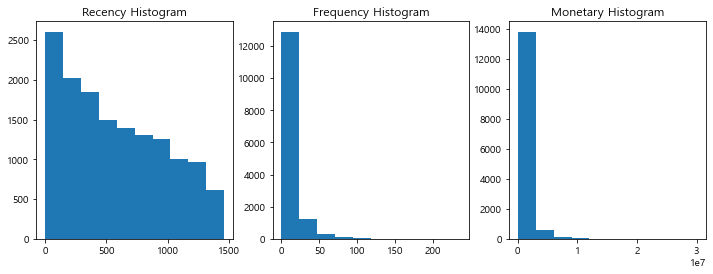

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(DF['recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(DF['frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(DF['monetary'])

- 히스토그램을 살펴보면, frequency와 monetary가 매우 skewed된 분포를 가지고 있음
- 군집화가 한쪽에 집중 될 가능성 多

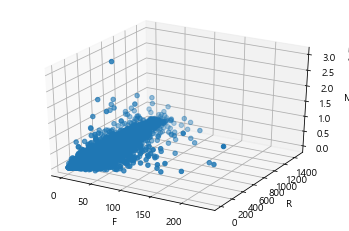

In [119]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = DF['frequency']
y = DF['recency']
z = DF['monetary']

ax.scatter(x, y, z, marker='o')

ax.set_xlabel('F')
ax.set_ylabel('R')
ax.set_zlabel('M')

plt.show()

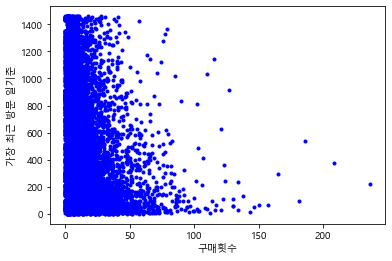

In [120]:
x = DF['frequency']
y = DF['recency']

plt.scatter(x, y, c='b', marker='.')

plt.xlabel('구매횟수')
plt.ylabel('가장 최근 방문 일기준')

plt.show()

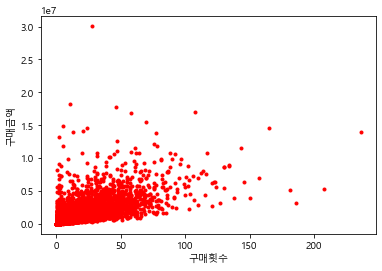

In [121]:
x = DF['frequency']
y = DF['monetary']

plt.scatter(x, y, c='r', marker='.')

plt.xlabel('구매횟수')
plt.ylabel('구매금액')

plt.show()

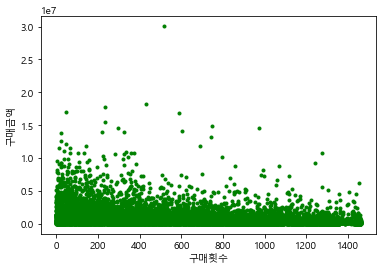

In [122]:
x = DF['recency']
y = DF['monetary']

plt.scatter(x, y, c='g', marker='.')

plt.xlabel('구매횟수')
plt.ylabel('구매금액')

plt.show()

### 라이브러리

In [123]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from datetime import datetime
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

**1. StandardScaler**
    각 특성의 평균을 0, 분산을 1로 스케일링합니다. 즉 데이터를 정규분포로 만듭니다. 하한값과 상한값이 존재하지 않을 수 있기에, 어떤 알고리즘에서는 문제가 있을 수 있습니다. 회귀보다 분류에 유용합니다.

**2. RobustScaler**
    각 특성들의 중앙값을 0, IQR(제3사분위수-제1사분위수,Q3-Q1)을 1로 스케일링합니다. StandardScaler와 비슷하지만, 이상치의 영향을 최소화합니다.

**3. MinMaxScaler(a,b)**
    각 특성의 하한값을 a, 상한값을 b로 스케일링합니다. a=0, b=1일 경우 Normalization으로 표기할 때도 있습니다. 분류보다 회귀에 유용합니다.

**4. MaxAbsScaler**
    각 특성을 절대값이 0과 1사이가 되도록 스케일링합니다. 즉, 모든 값은 -1과 1사이로 표현되며, 데이터가 양수일 경우 MinMaxScaler와 같습니다.

**5. Normalizer**
    앞의 4가지 스케일러는 각 특성(열)의 통계치를 이용하여 진행됩니다. 그러나 Normalizer의 경우 각 샘플(행)마다 적용되는 방식입니다. 이는 한 행의 모든 특성들 사이의 유클리드 거리(L2 norm)가 1이 되도록 스케일링합니다. 일반적인 데이터 전처리의 상황에서 사용되는 것이 아니라, 모델(특히나 딥러닝) 내 학습 벡터에 적용하며, 특히나 피쳐들이 다른 단위(키, 나이, 소득 등)라면 더더욱 사용하지 않습니다

In [124]:
DF.drop('최종방문일',axis=1,inplace=True)
scaler=MinMaxScaler()
ss=StandardScaler()
rs = RobustScaler()

clusterDF=scaler.fit_transform(DF)
clusterDF2=ss.fit_transform(DF)
clusterDF3 = rs.fit_transform(DF)

### MinMaxScaler

In [125]:
clusterDF

array([[0.00847458, 0.00372669, 0.        ],
       [0.09745763, 0.04295673, 0.        ],
       [0.17372881, 0.11145125, 0.        ],
       ...,
       [0.00423729, 0.0049911 , 1.        ],
       [0.00423729, 0.00159715, 1.        ],
       [0.04237288, 0.0175354 , 1.        ]])

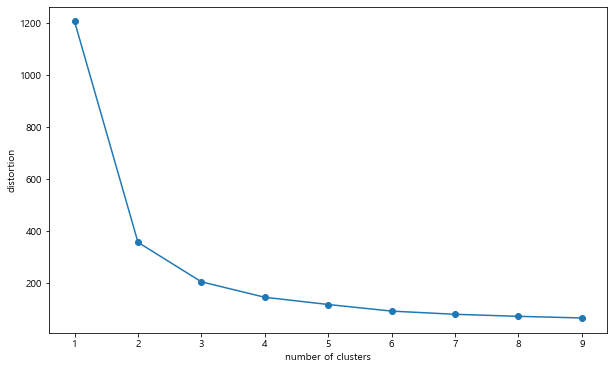

In [126]:
distortions=[]
for i in range(1,10):
    km=KMeans(n_clusters=i,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
    km.fit(clusterDF)
    # lnertia가 군집 내의 분산을 의미
    distortions.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortion')
plt.show()

### StandardScaler

In [127]:
clusterDF2

array([[-0.53233104, -0.53438926, -1.41667556],
       [ 0.9314917 ,  0.38785755, -1.41667556],
       [ 2.1861969 ,  1.99807389, -1.41667556],
       ...,
       [-0.60203688, -0.50466459,  2.17563173],
       [-0.60203688, -0.58445185,  2.17563173],
       [ 0.02531572, -0.20976464,  2.17563173]])

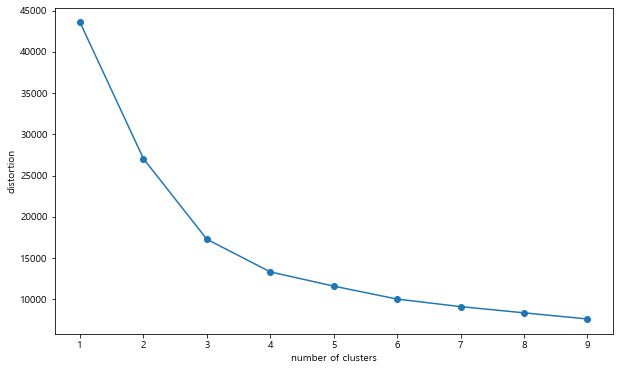

In [128]:
distortions=[]
for i in range(1,10):
    km=KMeans(n_clusters=i,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
    km.fit(clusterDF2)
    # lnertia가 군집 내의 분산을 의미
    distortions.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortion')
plt.show()

### RobustScaler

In [129]:
clusterDF3

array([[-0.18181818, -0.29873227, -0.74927114],
       [ 1.72727273,  1.18112213, -0.74927114],
       [ 3.36363636,  3.76490523, -0.74927114],
       ...,
       [-0.27272727, -0.25103552,  1.37900875],
       [-0.27272727, -0.37906364,  1.37900875],
       [ 0.54545455,  0.22216644,  1.37900875]])

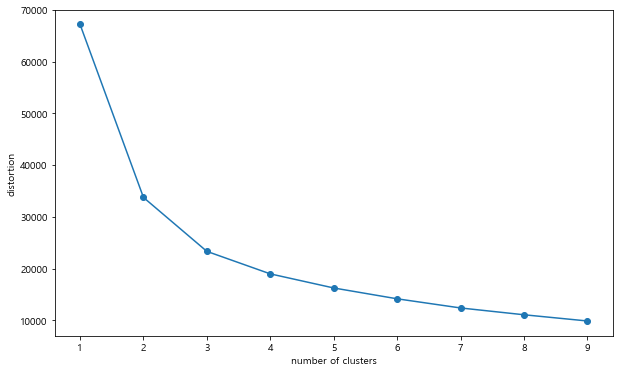

In [130]:
distortions=[]
for i in range(1,10):
    km=KMeans(n_clusters=i,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
    km.fit(clusterDF3)
    # lnertia가 군집 내의 분산을 의미
    distortions.append(km.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(range(1,10),distortions,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortion')
plt.show()

### K-means
1) MinMaxScaler

In [131]:
range_n_clusters=[2,3,4,5,6,7,8,9,10]

for n_clusters= 2 the average silhouette_score is: 0.5926054004365601
for n_clusters= 3 the average silhouette_score is: 0.5136654852590105
for n_clusters= 4 the average silhouette_score is: 0.472662035524969
for n_clusters= 5 the average silhouette_score is: 0.47491138820365664
for n_clusters= 6 the average silhouette_score is: 0.45915407857187424
for n_clusters= 7 the average silhouette_score is: 0.427139168321374
for n_clusters= 8 the average silhouette_score is: 0.3953438589082521
for n_clusters= 9 the average silhouette_score is: 0.39696842439466146
for n_clusters= 10 the average silhouette_score is: 0.4075124566827231


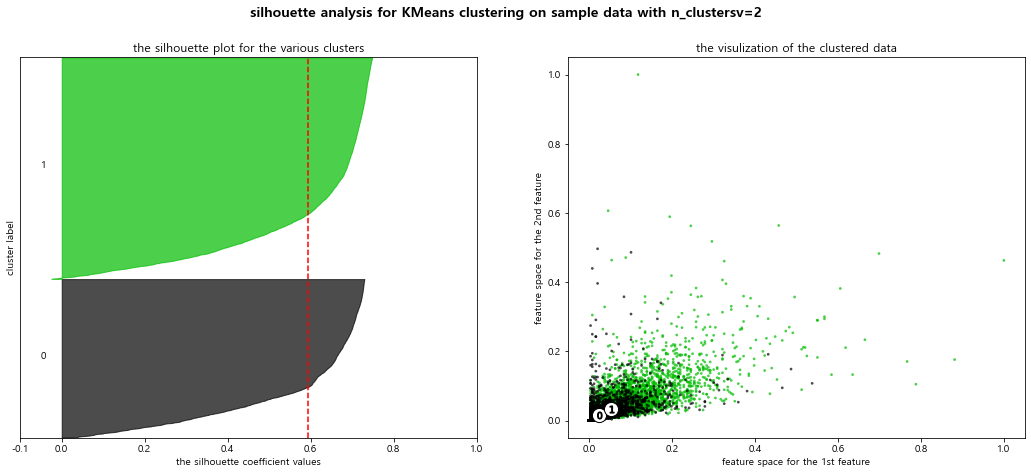

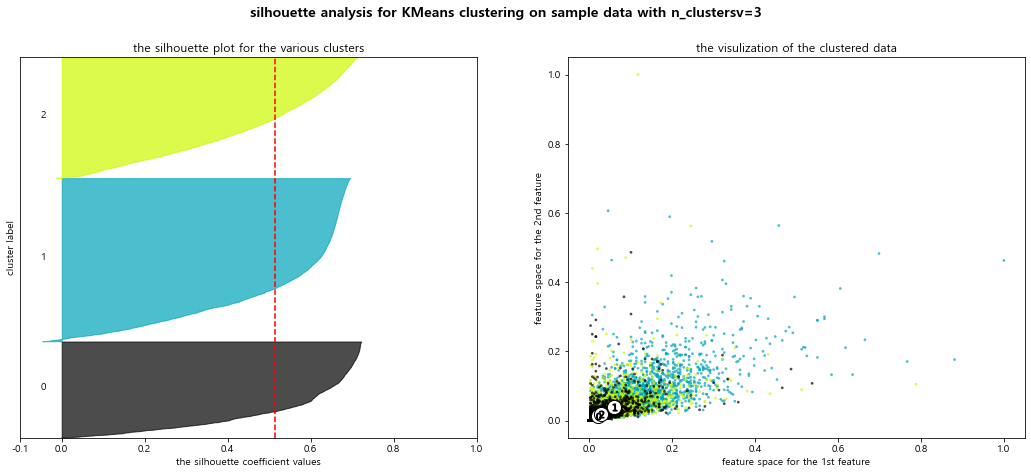

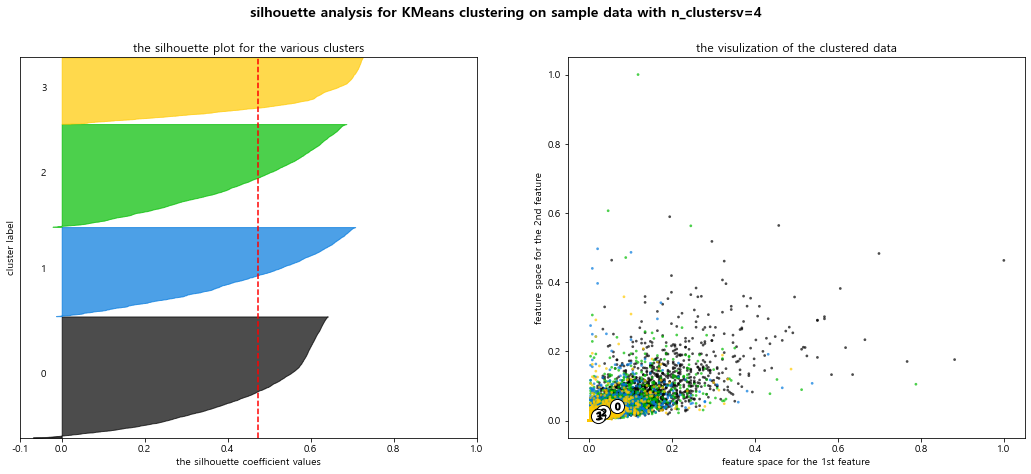

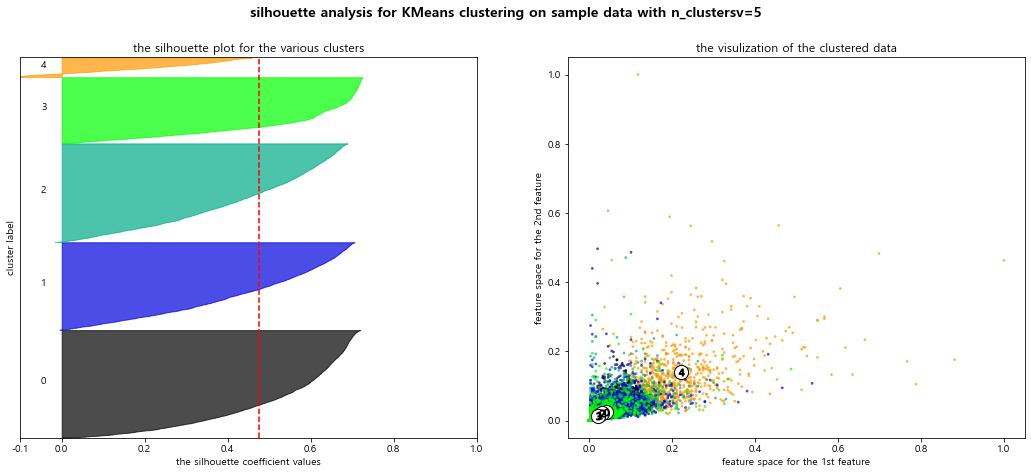

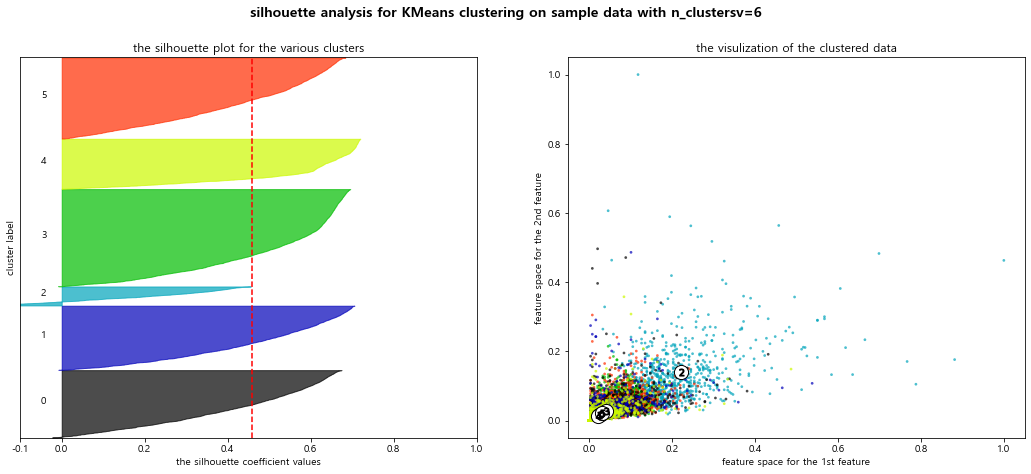

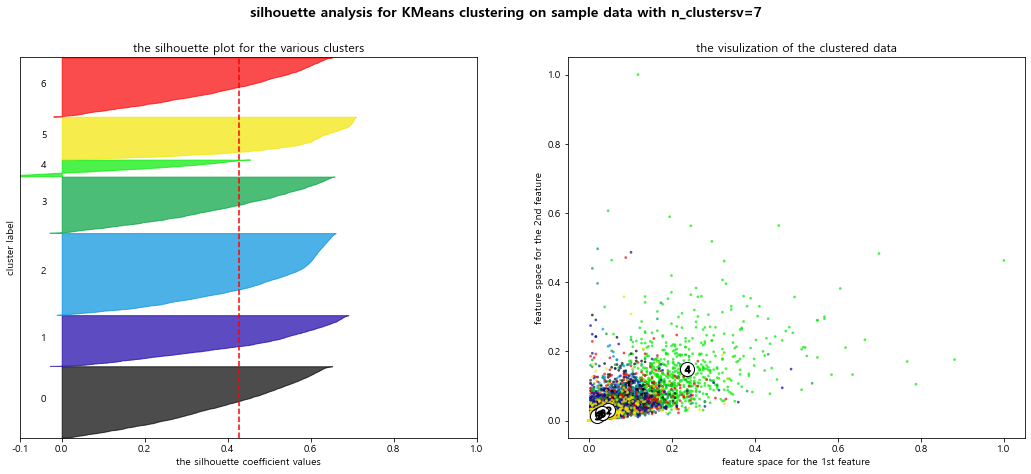

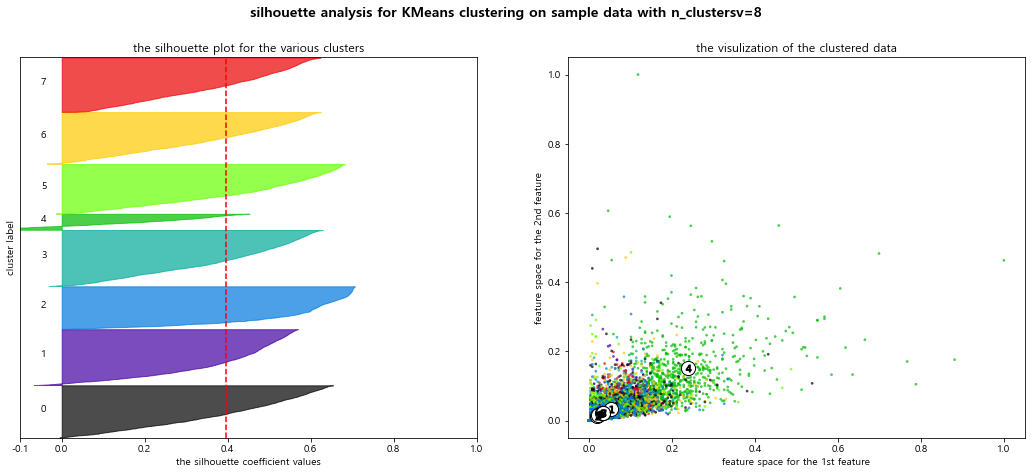

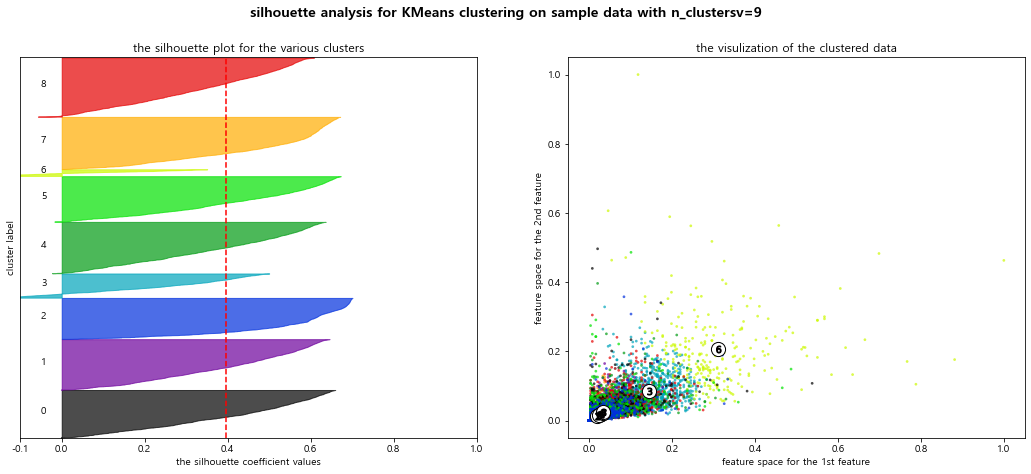

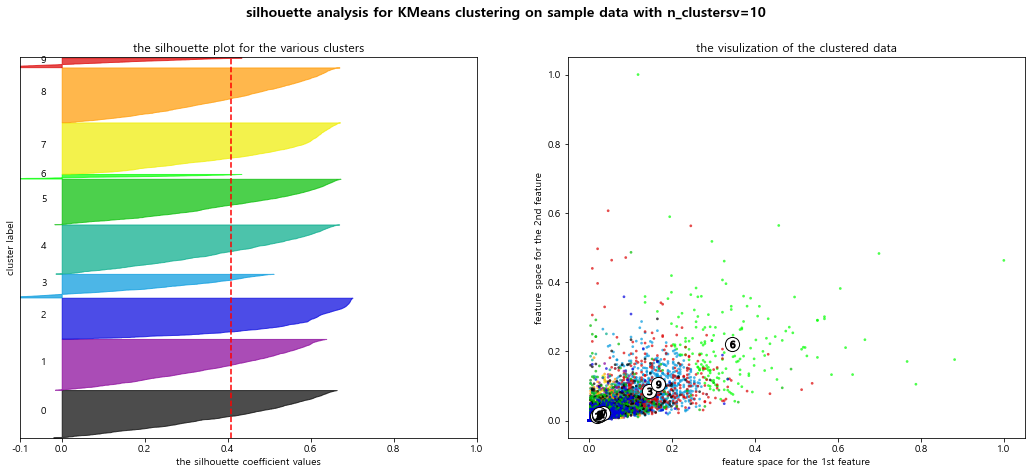

In [132]:
for n_clusters in range_n_clusters:
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2)=plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-0.1,1]) # 실루엣 계수는 -1,1 사이에 값이지만 이 실습에선 -0.1,1까지만 본다
    ax1.set_ylim([0,len(clusterDF)+(n_clusters+1)*10])
    
    clusterer=KMeans(n_clusters=n_clusters,random_state=10) #kmeans
    cluster_labels=clusterer.fit_predict(clusterDF)
    
    silhouette_avg=silhouette_score(clusterDF,cluster_labels)
    print('for n_clusters=',n_clusters,
         'the average silhouette_score is:',silhouette_avg)
    
    sample_silhouette_values=silhouette_samples(clusterDF,cluster_labels)
    
    y_lower=10
    for i in range(n_clusters):
        # n_clusters=2,3,4,5,6
        # i 는 0-n_clusters 즉, 분류된 군집의 라벨
        ith_cluster_silhouette_values=\
            sample_silhouette_values[cluster_labels==i]
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        
        color=cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i)) # 군집 번호를 가운데 표시
        y_lower=y_upper+10 # 다음 그림의 시작점 = 지금 그림의 끝점 + 10
        
    ax1.set_title('the silhouette plot for the various clusters')
    ax1.set_xlabel('the silhouette coefficient values')
    ax1.set_ylabel('cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='--') # 모든 개별 데이터의 실루엣값 평균 보조선
    
    ax1.set_yticks([]) # y출 눈금 지우기
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    # 2번째 그래프 ax2
    colors=cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(clusterDF[:,0],clusterDF[:,1],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k') #라벨에 따라 다른 색으로 산점도
    
    #군집의 중심에 원그림
    centers=clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    
    #군집의 중심에 군집번호 표시
    for i, c in enumerate(centers):
        ax2.scatter(c[0],c[1],marker='$%d$' % i, alpha=1,s=50,edgecolor='k')
        
    ax2.set_title('the visulization of the clustered data')
    ax2.set_xlabel('feature space for the 1st feature')
    ax2.set_ylabel('feature space for the 2nd feature')
    plt.suptitle(("silhouette analysis for KMeans clustering on sample data " "with n_clustersv=%d" % n_clusters),fontsize=14,fontweight='bold')
plt.show()

In [133]:
kmeans=KMeans(n_clusters=3, init='k-means++',max_iter=200,random_state=0)
cluster_labels=kmeans.fit_predict(DF)
DF=pd.DataFrame(DF)
DF['label']=cluster_labels

In [134]:
DF.groupby(['label']).mean()

,frequency,monetary,recency
label,,,
0,5.507703,3.757121e+05,620.915438
1,26.966125,2.297354e+06,361.661253
2,52.775862,7.095951e+06,287.262069


**label=0**
R↑ F↓ M↓

**label=1**
R↓ F↓ M↑

**label=2**
R↓ F↑ M↑

In [135]:
DF['label'].value_counts()

0    12074
1     2155
2      290
Name: label, dtype: int64

2) StandardScaler

for n_clusters= 2 the average silhouette_score is: 0.5606105711747437
for n_clusters= 3 the average silhouette_score is: 0.44187962093995814
for n_clusters= 4 the average silhouette_score is: 0.4469051822989132
for n_clusters= 5 the average silhouette_score is: 0.42700797860991085
for n_clusters= 6 the average silhouette_score is: 0.36752351504402203
for n_clusters= 7 the average silhouette_score is: 0.3690227691980188
for n_clusters= 8 the average silhouette_score is: 0.3801623876989876
for n_clusters= 9 the average silhouette_score is: 0.38199922503596606
for n_clusters= 10 the average silhouette_score is: 0.3701371207782086


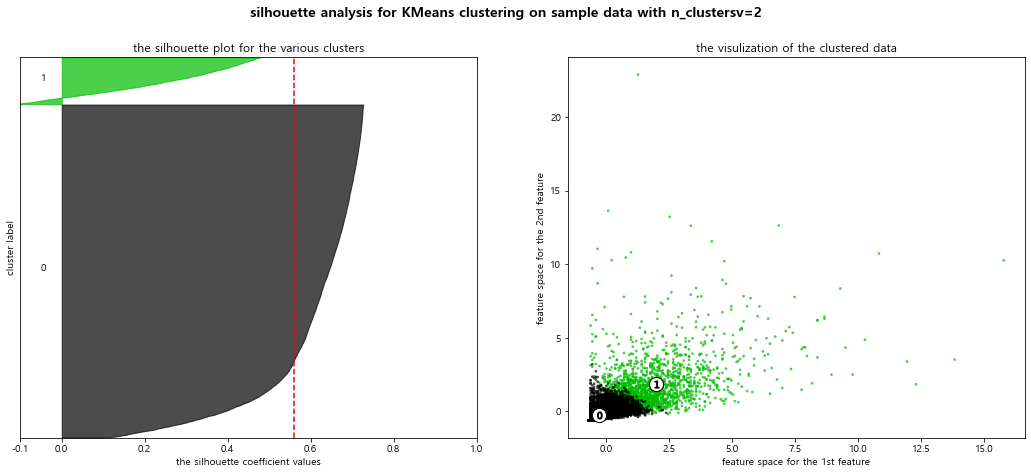

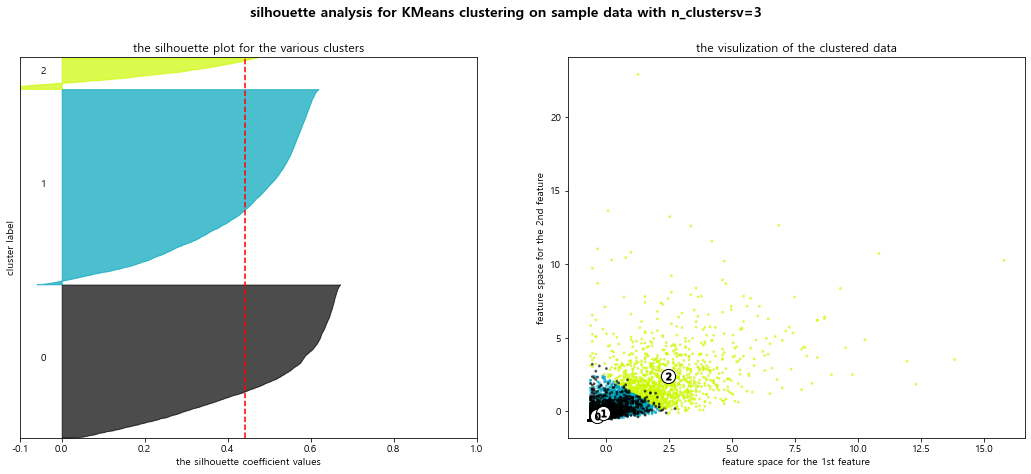

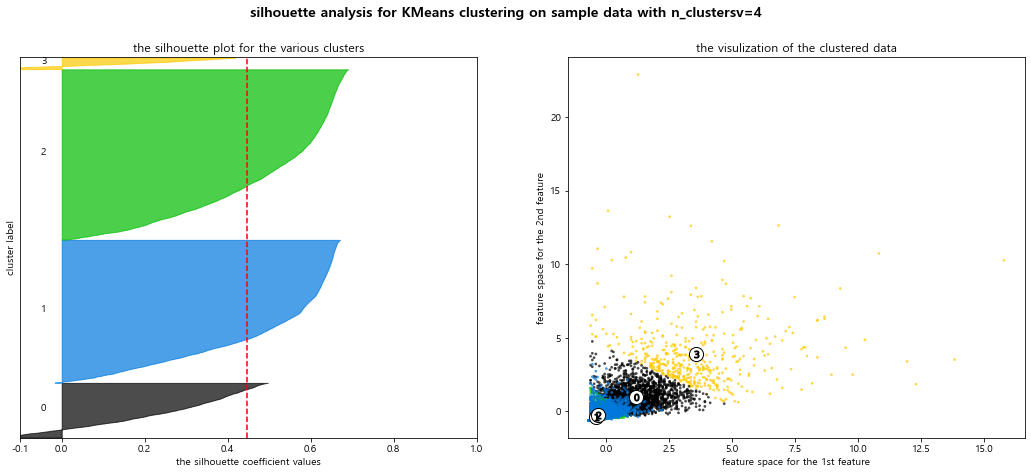

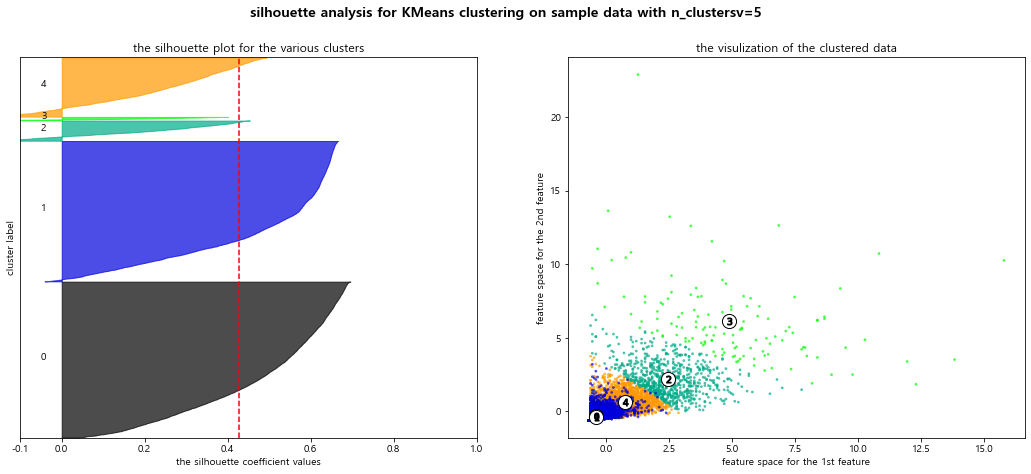

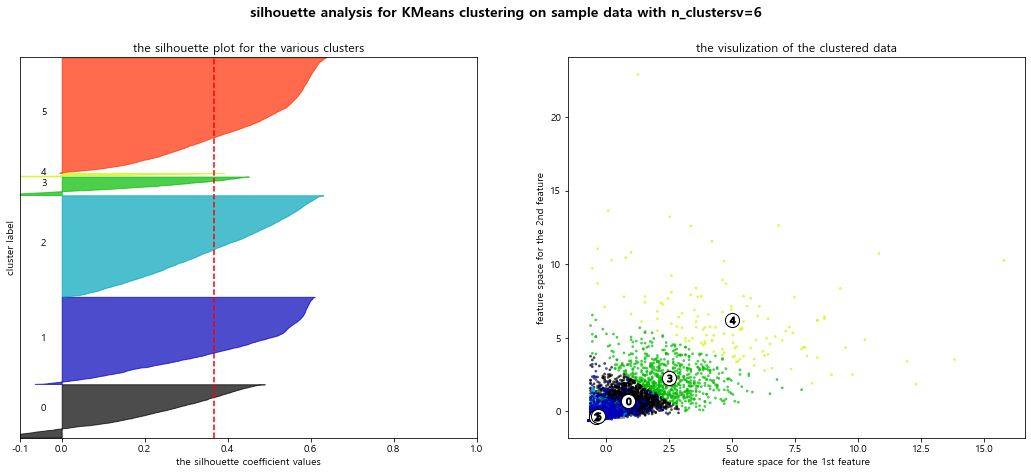

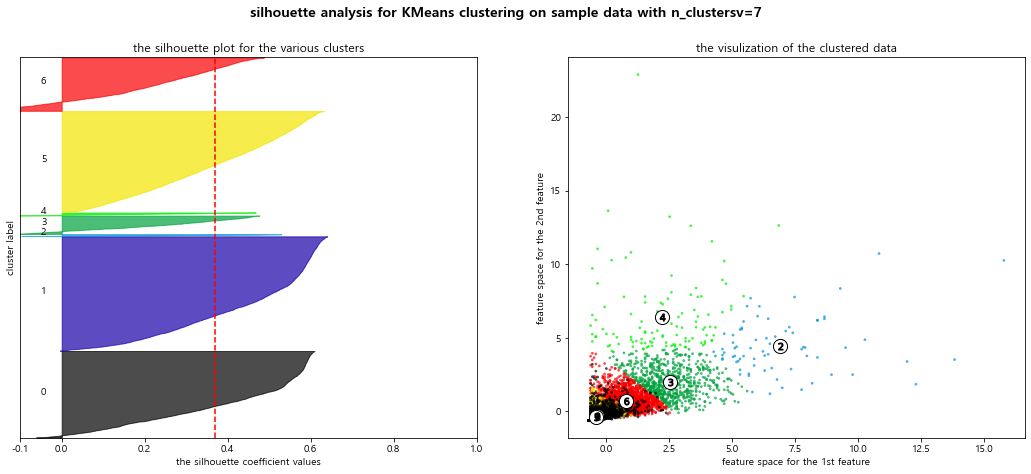

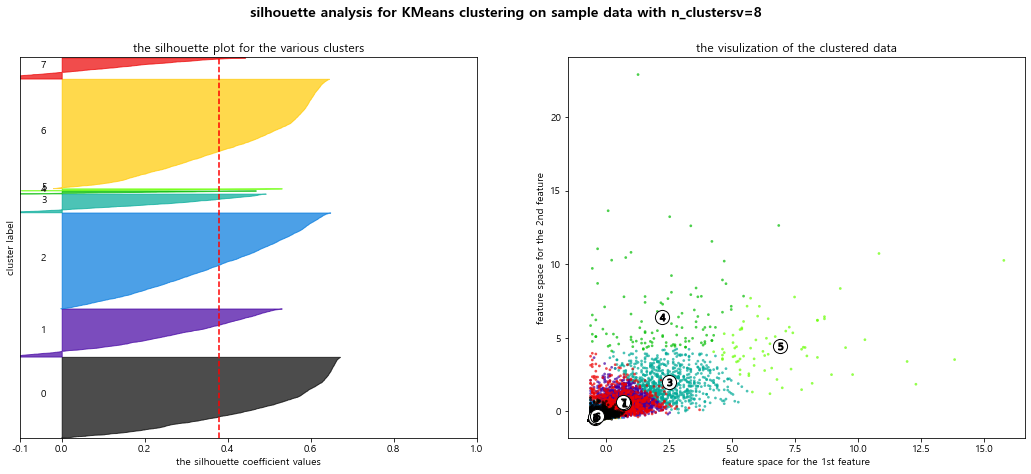

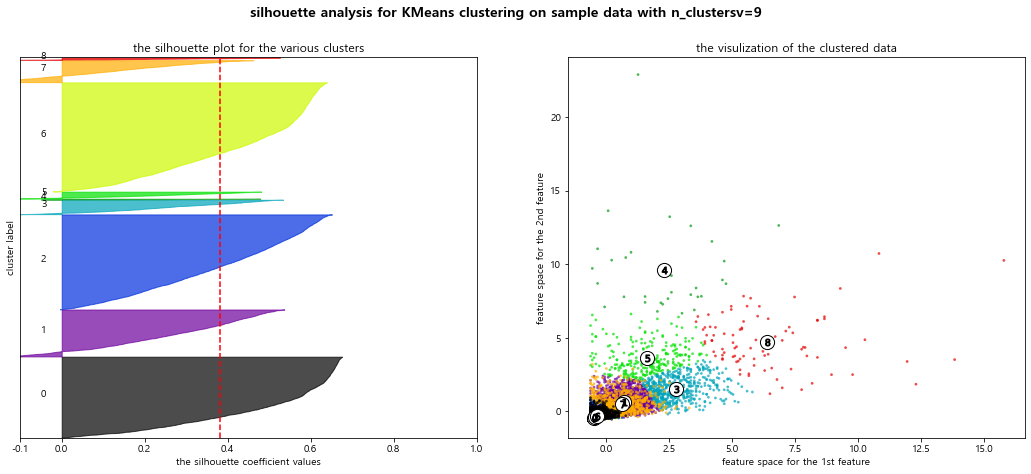

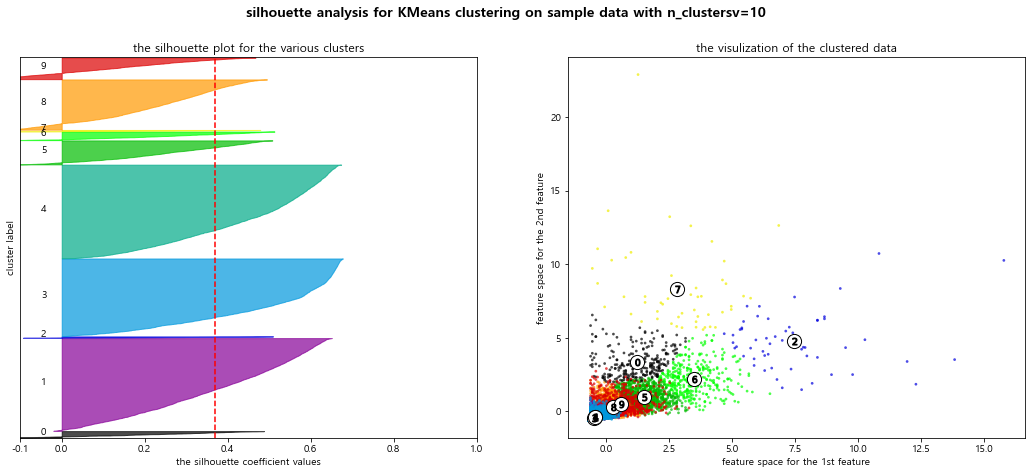

In [136]:
for n_clusters in range_n_clusters:
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2)=plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-0.1,1]) # 실루엣 계수는 -1,1 사이에 값이지만 이 실습에선 -0.1,1까지만 본다
    ax1.set_ylim([0,len(clusterDF2)+(n_clusters+1)*10])
    
    clusterer=KMeans(n_clusters=n_clusters,random_state=10) #kmeans
    cluster_labels=clusterer.fit_predict(clusterDF2)
    
    silhouette_avg=silhouette_score(clusterDF2,cluster_labels)
    print('for n_clusters=',n_clusters,
         'the average silhouette_score is:',silhouette_avg)
    
    sample_silhouette_values=silhouette_samples(clusterDF2,cluster_labels)
    
    y_lower=10
    for i in range(n_clusters):
        # n_clusters=2,3,4,5,6
        # i 는 0-n_clusters 즉, 분류된 군집의 라벨
        ith_cluster_silhouette_values=\
            sample_silhouette_values[cluster_labels==i]
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        
        color=cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i)) # 군집 번호를 가운데 표시
        y_lower=y_upper+10 # 다음 그림의 시작점 = 지금 그림의 끝점 + 10
        
    ax1.set_title('the silhouette plot for the various clusters')
    ax1.set_xlabel('the silhouette coefficient values')
    ax1.set_ylabel('cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='--') # 모든 개별 데이터의 실루엣값 평균 보조선
    
    ax1.set_yticks([]) # y출 눈금 지우기
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    # 2번째 그래프 ax2
    colors=cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(clusterDF2[:,0],clusterDF2[:,1],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k') #라벨에 따라 다른 색으로 산점도
    
    #군집의 중심에 원그림
    centers=clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    
    #군집의 중심에 군집번호 표시
    for i, c in enumerate(centers):
        ax2.scatter(c[0],c[1],marker='$%d$' % i, alpha=1,s=50,edgecolor='k')
        
    ax2.set_title('the visulization of the clustered data')
    ax2.set_xlabel('feature space for the 1st feature')
    ax2.set_ylabel('feature space for the 2nd feature')
    plt.suptitle(("silhouette analysis for KMeans clustering on sample data " "with n_clustersv=%d" % n_clusters),fontsize=14,fontweight='bold')
plt.show()

In [137]:
kmeans=KMeans(n_clusters=4, init='k-means++',max_iter=200,random_state=0)
cluster_labels=kmeans.fit_predict(DF)
DF['label(ss)']=cluster_labels

In [138]:
DF.groupby(['label(ss)']).mean()

,frequency,monetary,recency,label
label(ss),,,,
0,4.484022,2.952710e+05,640.188981,0.000000
1,40.280282,4.015128e+06,310.600000,1.245070
2,19.820906,1.562649e+06,405.119872,0.577595
3,59.732759,9.470898e+06,274.862069,2.000000


**label(ss)=0**
R↑ F↓ M↓


**label(ss)=1**
R↑ F↑ M↑


**label(ss)=2**
R↓ F↓ M↑


**label(ss)=3**
R↓ F↑ M↑

In [139]:
DF['label(ss)'].value_counts()

0    10890
2     2803
1      710
3      116
Name: label(ss), dtype: int64

3) RobustScaler

for n_clusters= 2 the average silhouette_score is: 0.6958974294451478
for n_clusters= 3 the average silhouette_score is: 0.5635497499569525
for n_clusters= 4 the average silhouette_score is: 0.4789290596540091
for n_clusters= 5 the average silhouette_score is: 0.36145243500772356
for n_clusters= 6 the average silhouette_score is: 0.36531248054269655
for n_clusters= 7 the average silhouette_score is: 0.3681966149098656
for n_clusters= 8 the average silhouette_score is: 0.36826300292838315
for n_clusters= 9 the average silhouette_score is: 0.3729132879745535
for n_clusters= 10 the average silhouette_score is: 0.3707367012558347


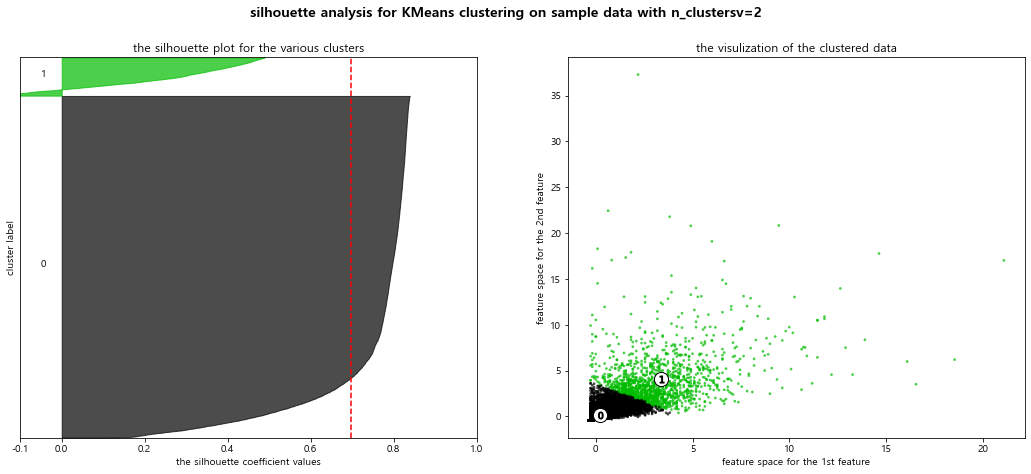

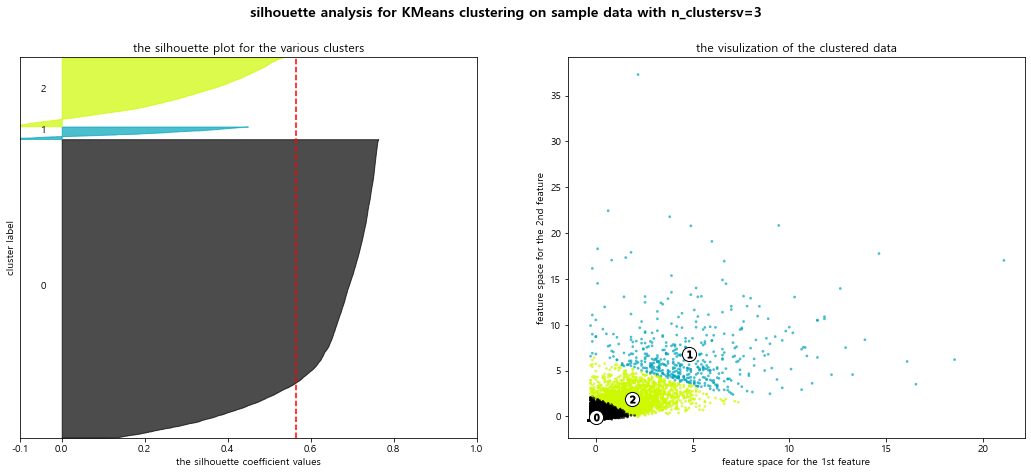

In [ ]:
for n_clusters in range_n_clusters:
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2)=plt.subplots(1,2)
    fig.set_size_inches(18,7)
    
    ax1.set_xlim([-0.1,1]) # 실루엣 계수는 -1,1 사이에 값이지만 이 실습에선 -0.1,1까지만 본다
    ax1.set_ylim([0,len(clusterDF3)+(n_clusters+1)*10])
    
    clusterer=KMeans(n_clusters=n_clusters,random_state=10) #kmeans
    cluster_labels=clusterer.fit_predict(clusterDF3)
    
    silhouette_avg=silhouette_score(clusterDF3,cluster_labels)
    print('for n_clusters=',n_clusters,
         'the average silhouette_score is:',silhouette_avg)
    
    sample_silhouette_values=silhouette_samples(clusterDF3,cluster_labels)
    
    y_lower=10
    for i in range(n_clusters):
        # n_clusters=2,3,4,5,6
        # i 는 0-n_clusters 즉, 분류된 군집의 라벨
        ith_cluster_silhouette_values=\
            sample_silhouette_values[cluster_labels==i]
        
        ith_cluster_silhouette_values.sort()
        size_cluster_i=ith_cluster_silhouette_values.shape[0]
        y_upper=y_lower+size_cluster_i
        
        color=cm.nipy_spectral(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0,ith_cluster_silhouette_values,facecolor=color,edgecolor=color,alpha=0.7)
        ax1.text(-0.05,y_lower+0.5*size_cluster_i,str(i)) # 군집 번호를 가운데 표시
        y_lower=y_upper+10 # 다음 그림의 시작점 = 지금 그림의 끝점 + 10
        
    ax1.set_title('the silhouette plot for the various clusters')
    ax1.set_xlabel('the silhouette coefficient values')
    ax1.set_ylabel('cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='--') # 모든 개별 데이터의 실루엣값 평균 보조선
    
    ax1.set_yticks([]) # y출 눈금 지우기
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    # 2번째 그래프 ax2
    colors=cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(clusterDF3[:,0],clusterDF3[:,1],marker='.',s=30,lw=0,alpha=0.7,c=colors,edgecolor='k') #라벨에 따라 다른 색으로 산점도
    
    #군집의 중심에 원그림
    centers=clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1],marker='o',c='white',alpha=1,s=200,edgecolor='k')
    
    #군집의 중심에 군집번호 표시
    for i, c in enumerate(centers):
        ax2.scatter(c[0],c[1],marker='$%d$' % i, alpha=1,s=50,edgecolor='k')
        
    ax2.set_title('the visulization of the clustered data')
    ax2.set_xlabel('feature space for the 1st feature')
    ax2.set_ylabel('feature space for the 2nd feature')
    plt.suptitle(("silhouette analysis for KMeans clustering on sample data " "with n_clustersv=%d" % n_clusters),fontsize=14,fontweight='bold')
plt.show()

In [ ]:
kmeans=KMeans(n_clusters=3, init='k-means++',max_iter=200,random_state=0)
cluster_labels=kmeans.fit_predict(DF[['frequency', 'monetary', 'recency']])
DF['label(rs)']=cluster_labels

In [ ]:
DF.groupby(['label(rs)']).mean()

**label(rs)=0**
R↑ F↓ M↓


**label(rs)=1**
R↓ F↓ M↑


**label(rs)=2**
R↓ F↑ M↑


In [ ]:
DF['label(rs)'].value_counts()

In [ ]:
pos.set_index('고객번호',inplace=True)

In [ ]:
customer=pd.concat([pos,DF],axis=1)
customer.drop(['frequency','monetary','recency'],axis=1,inplace=True)
customer.reset_index(inplace=True)

In [ ]:
customer

In [ ]:
customer.to_excel('./길음신관고객분류.xlsx', index=False, encoding='cp949')